In [30]:
#Making the standard imports
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
import datetime
import numpy as np
import pandas as pd
from backtrader import talib
import backtrader.feeds as btfeeds
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress


In [31]:
def momentum_func(self, price_array):
    r = np.log(price_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return (annualized * (rvalue ** 2))


class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    params = dict(period=30)
    func = momentum_func

In [32]:
class Strategy(bt.Strategy):
    params = dict(
        momentum=Momentum,
        momentum_period=90,
        num_positions=2,
        when=bt.timer.SESSION_START,
        timer=True,
        monthdays=[1],
        monthcarry=True,
        printlog=True
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.i = 0
        self.securities = self.datas[1:]
        self.inds = {}

        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )

        for security in self.securities:
            self.inds[security] = self.p.momentum(security,
                                                  period=self.p.momentum_period)

    def notify_timer(self, timer, when, *args, **kwargs):
        if self._getminperstatus() < 0:
            self.rebalance()

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s][0], reverse=True)
        pos_size = 1 / self.p.num_positions

        # Sell stocks no longer meeting ranking filter.
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)

        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            self.order_target_percent(d, target=pos_size)

    def next(self):
        self.notify_timer(self, self.p.timer, self.p.when)

    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period,
                  self.p.num_positions,
                  self.broker.getvalue()),
                 doprint=True)
    def notify_order(self, order):
        #print(type(order), 'Is Buy ', order.isbuy())
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                    self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                    self.buyprice = order.executed.price
                    self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        self.order = None
    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed:
            print('{} {} Closed: PnL Gross {}, Net {}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2)))




In [33]:
#Variable for our starting cash
startcash = 10000

#Create an instance of cerebro
cerebro = bt.Cerebro()

#Add our strategy
cerebro.addstrategy(Strategy)

#create our data list
datalist = ['ADANIGREEN.csv','ADANIPORTS.csv','APOLLOHOSP.csv','ASHOKLEY.csv','ASIANPAINT.csv','AUROPHARMA.csv','AXISBANK.csv']

#Loop through the list adding to cerebro.
for i in datalist:
    dataframe =pd.read_csv('/home/lokendra/Downloads/Research-Stuff/'+i,
                                skiprows=0,
                                header=0,
                                parse_dates=True,
                                index_col=0)
    data = bt.feeds.PandasData(dataname=dataframe)
    cerebro.adddata(data)


# Set our desired cash start
cerebro.broker.setcash(startcash)

# Run over everything
cerebro.run()

#Get final portfolio Value
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#Print out the final result
print('Final Portfolio Value: ${}'.format(portvalue))
print('P/L: ${}'.format(pnl))


2018-07-04, BUY EXECUTED, Price: 1296.00, Cost: 3888.00, Comm 0.00
2018-07-04, BUY EXECUTED, Price: 1053.15, Cost: 4212.60, Comm 0.00
2018-07-16, BUY EXECUTED, Price: 977.00, Cost: 977.00, Comm 0.00
2018-07-20, Order Canceled/Margin/Rejected
2018-08-16, Order Canceled/Margin/Rejected
2018-08-17, SELL EXECUTED, Price: 1140.00, Cost: 5189.60, Comm 0.00
2018-08-17, BUY EXECUTED, Price: 630.00, Cost: 5040.00, Comm 0.00
2018-08-17  Closed: PnL Gross 510.4, Net 510.4
2018-09-05, BUY EXECUTED, Price: 1314.50, Cost: 1314.50, Comm 0.00
2018-09-11, Order Canceled/Margin/Rejected
2018-09-12, Order Canceled/Margin/Rejected
2018-09-14, Order Canceled/Margin/Rejected
2018-09-17, Order Canceled/Margin/Rejected
2018-09-18, SELL EXECUTED, Price: 1306.00, Cost: 5202.50, Comm 0.00
2018-09-18, BUY EXECUTED, Price: 793.70, Cost: 4762.20, Comm 0.00
2018-09-18  Closed: PnL Gross 21.5, Net 21.5
2018-11-01, Order Canceled/Margin/Rejected
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Order Canceled/Mar

<IPython.core.display.Javascript object>


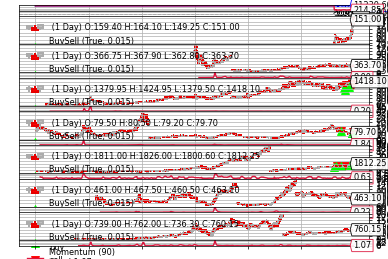

[[<Figure size 432x288 with 15 Axes>]]

In [37]:
cerebro.plot(volume=False)